Project 1 Predicting Diabetes Risk Using Patient Health Indicators

## Step 1: Load data

In [1]:
import pandas as pd

df = pd.read_csv('/content/diabetes.csv')

# Preview dataset
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Step 2a: Basic Data Checks

In [2]:
# Step 2a: Basic Data Checks

# 1. Dataset info
print("===== Dataset Info =====")
print(df.info())

# 2. Statistical summary
print("\n===== Summary Statistics =====")
print(df.describe())

# 3. Check for missing values
print("\n===== Missing Values =====")
print(df.isnull().sum())

# 4. Check for duplicate rows
print("\n===== Duplicates =====")
print("Number of duplicate rows:", df.duplicated().sum())

# 5. Target variable distribution
print("\n===== Outcome Distribution =====")
print(df['Outcome'].value_counts(normalize=True))

===== Dataset Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

===== Summary Statistics =====
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.89

## Step 2b: Quantify "Zeros-as-Missing"

### Why Zero Is a Problem
In this dataset, some medical features use 0 as a placeholder for missing data because:

.Glucose cannot be 0 (living person always has glucose in blood).

. BloodPressure (diastolic) cannot be 0.

. SkinThickness measured as mm cannot be 0.

. Insulin level cannot be 0.

. BMI cannot be 0 (unless weight is 0).

. Only Pregnancies can legitimately be 0 (women with no pregnancies).

So we must treat 0s in those 5 columns as missing.

In [3]:
# Count zeros in each column
zero_counts = (df == 0).sum()
print("===== Zero counts per column =====")
print(zero_counts)

===== Zero counts per column =====
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


## Step 2c: Convert Problematic Zeros → NaN

In [4]:
import numpy as np

# Columns where 0 should be treated as missing
cols_with_invalid_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zeros with NaN
df[cols_with_invalid_zeros] = df[cols_with_invalid_zeros].replace(0, np.nan)

# Confirm how many NaNs we now have
print(df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Step 3a: Median Imputation

In [5]:
# Step 3a: Median Imputation for missing values
for col in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    df[col].fillna(df[col].median(), inplace=True)

# Check again
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-4009210738.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


## Step 3b: Visualizations

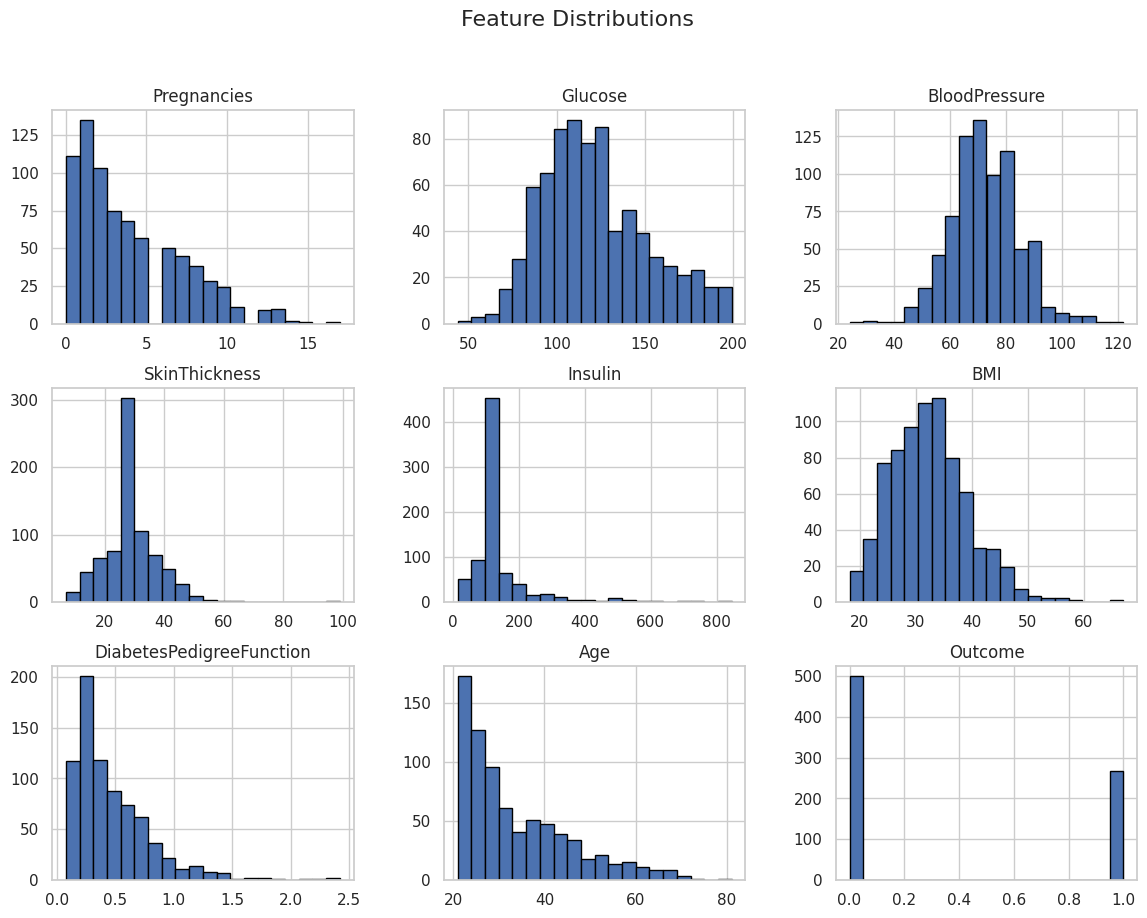

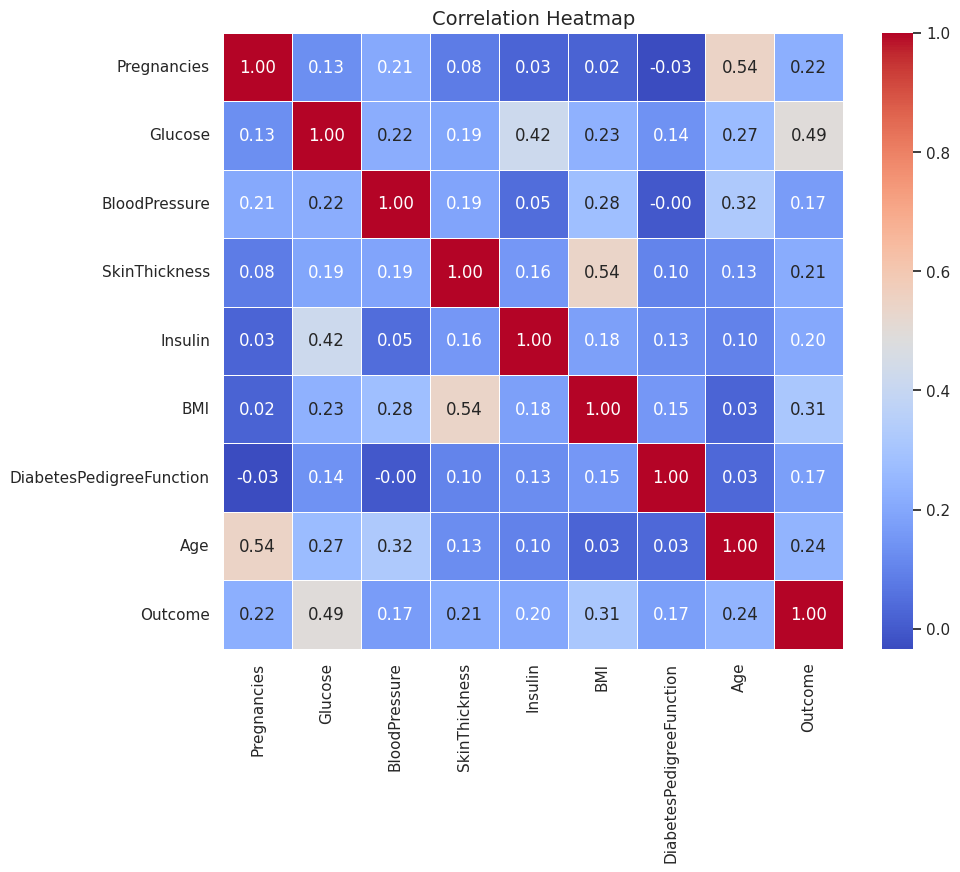

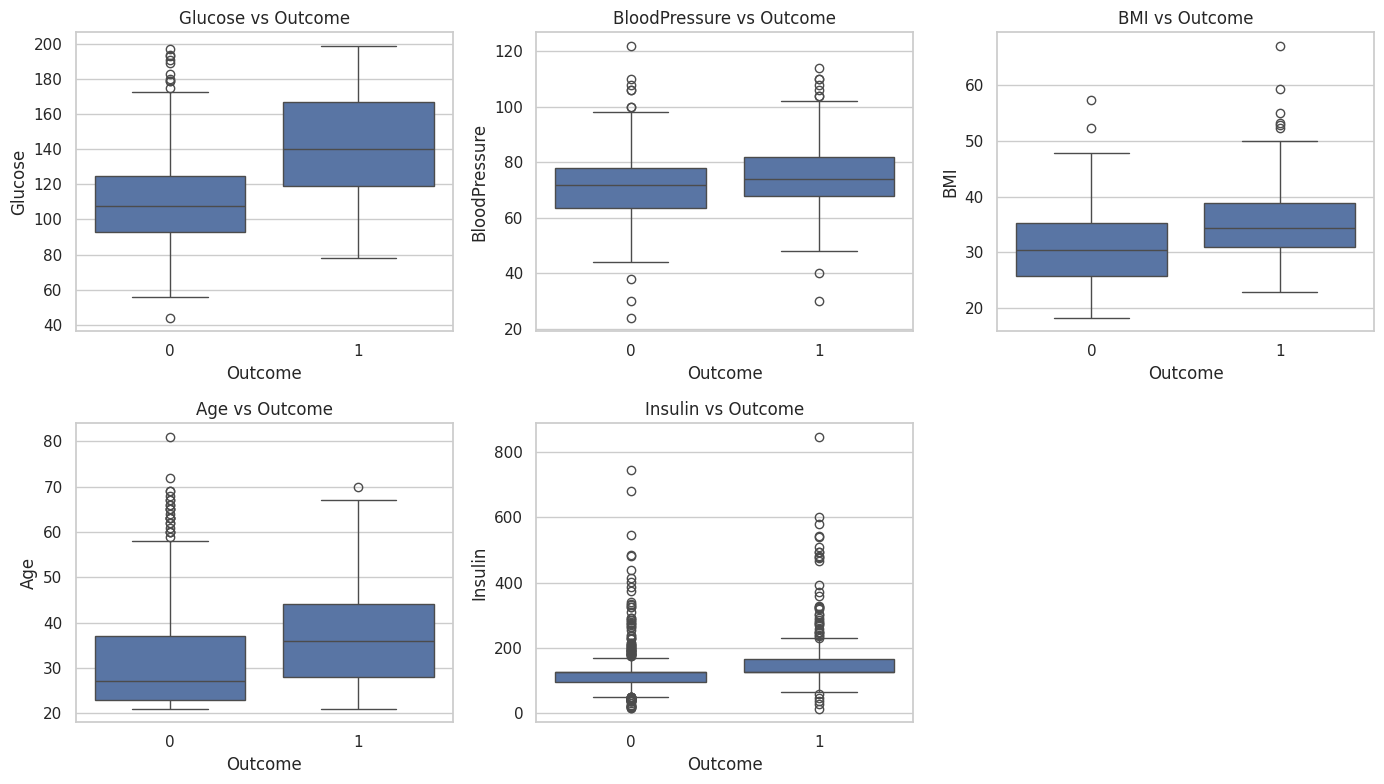

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# 1. Distribution plots for every feature
df.hist(figsize=(14,10), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

# 3. Boxplots: feature vs Outcome (0=No Diabetes, 1=Diabetes)
features = ["Glucose", "BloodPressure", "BMI", "Age", "Insulin"]
plt.figure(figsize=(14,8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="Outcome", y=col, data=df)
    plt.title(f"{col} vs Outcome")
plt.tight_layout()
plt.show()

## **Interpretation of EDA Visuals**

### **1. Distribution Plots (Histograms)**

**Glucose**: Right‑skewed, with higher values more common in diabetics. Clear separation between healthy vs diabetic.
    
**Blood Pressure**: More centered; less separation between classes.
    
**BMI**: Right‑skewed but does differ — diabetics generally cluster higher.
    
**Insulin**: Highly skewed, long right tail (few patients with extremely high insulin).
    
**SkinThickness**: Many low values (after imputation), distribution still skewed.
    
**Age**: Patients span 20–80, diabetics tend to be older.

### **2. Correlation Heatmap**

**Strongest link**: Glucose ↔ Outcome (positive).
    
**Moderate links**: BMI ↔ Outcome, Age ↔ Outcome, Insulin ↔ Outcome.
    
Other correlations are weak, but still potentially informative when combined.
    
### **3. Boxplots by Outcome**

**Glucose**: Clear upward shift for Outcome=1 (diabetics).
    
**BMI**: Higher in diabetics, though with some overlap.
    
**Age**: Diabetic group tends to be older.
    
**Insulin**: Very spread out, with diabetics shifted somewhat higher.
    
**Blood Pressure**: Differences smaller, less discriminative.

## **Key Insights from EDA**

1. Glucose is the single strongest predictor.
    
2. BMI, Age, Insulin carry additional signal.
    
3. Blood Pressure and SkinThickness add less, but may help marginally.
    
4. Data is moderately imbalanced (~65% non‑diabetic vs 35% diabetic).


## **Step 4: Preprocessing for Modeling.**

## **Step 4a: Train/Test Split**
We will split data into training and test sets **(80/20 split is common)**.

In [7]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train-test split (80/20 stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, " Test set:", X_test.shape)
print("Target distribution in training:", y_train.mean().round(3))

Train set: (614, 8)  Test set: (154, 8)
Target distribution in training: 0.349


## **Step 4b: Feature Scaling**
We will standardize numeric features to mean=0, std=1. This is critical for models like Logistic Regression, KNN, SVM.

In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Step 4c: Handle Class Imbalance**
Outcome ratio **≈ 65:35**. Not extreme, but still relevant. Two main routes:

1. Use class weights — simple, supported by LogisticRegression, SVM, etc.
   
2. Resampling methods like **SMOTE** (synthetic oversampling of minority class).

In [9]:
# Option 1: Use class weights (built into many models, e.g., LogisticRegression)

# Option 2: Example with SMOTE resampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Original training distribution:", y_train.value_counts(normalize=True))
print("Resampled training distribution:", y_train_resampled.value_counts(normalize=True))

Original training distribution: Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64
Resampled training distribution: Outcome
0    0.5
1    0.5
Name: proportion, dtype: float64


## **Step 5: Model Training & Evaluation Plan**
Since this is a structured classification task, we will implement and compare the models below listed:

### **Models to Compare**

**Logistic Regression** (baseline, interpretable)

**Decision Tree** (simple, good for feature importance, non-linear splits)

**Random Forest** (ensemble method, reduces variance of decision trees)

**XGBoost** (gradient boosting, strong performance on tabular datasets)

### **Evaluation Metrics**

**Accuracy** → overall correct predictions

**Precision & Recall** → because false negatives (missed diabetics) are high-risk in a medical context

**F1-score** → balance between precision and recall
    
**ROC-AUC** → to evaluate separation of diabetic vs non-diabetic across thresholds
    
### **Visualization Tools**

**Correlation heatmaps** (already done)
    
**ROC curves** (to compare model performance visually)
    
**Confusion matrices** (to see prediction errors by class)
    
**Feature importance plots** (Decision Tree, Random Forest, XGBoost)
    
**Distribution plots** (already covered in EDA)


### **Step 5a: Train the Planned Models**

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]

    print("===== ", name, " =====")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
    print("\n")

=====  Logistic Regression  =====
Confusion Matrix:
 [[74 26]
 [18 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.58      0.67      0.62        54

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.73      0.71      0.72       154

ROC-AUC: 0.811


=====  Decision Tree  =====
Confusion Matrix:
 [[75 25]
 [21 33]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77       100
           1       0.57      0.61      0.59        54

    accuracy                           0.70       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.70      0.70       154

ROC-AUC: 0.681


=====  Random Forest  =====
Confusion Matrix:
 [[77 23]
 [15 39]]

Classification Report:
               precision    recall

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:15:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=====  XGBoost  =====
Confusion Matrix:
 [[77 23]
 [19 35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79       100
           1       0.60      0.65      0.62        54

    accuracy                           0.73       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154

ROC-AUC: 0.808




### **Model Performance Summary**

| Model              | Accuracy | Precision (Pos) | Recall (Pos) | F1 (Pos) | ROC‑AUC |
|--------------------|----------|-----------------|--------------|----------|---------|
| Logistic Regression | 0.71     | 0.58            | 0.67         | 0.62     | 0.811   |
| Decision Tree       | 0.70     | 0.57            | 0.61         | 0.59     | 0.681   |
| Random Forest       | 0.75     | 0.63            | 0.72         | 0.67     | 0.814   |
| XGBoost             | 0.73     | 0.60            | 0.65         | 0.62     | 0.808   |

*   List item
*   List item



## **Key Insights**

**. Random Forest** is the strongest performer; best balance with accuracy (0.75), stronger recall for positives (0.72), highest F1 (0.67), and highest ROC‑AUC (0.814).

**. Logistic Regression and XGBoost** are close behind with similar ROC‑AUC (~0.81), meaning they separate classes fairly well across thresholds.

**. Decision Tree** underperforms with lower ROC‑AUC (0.681), expected since single trees tend to overfit.


### **Step 5.b: HYPERPARAMETER TUNING WITH RANDOMIZEDSEARCHCV**
#### **Goal: Improve model performance by finding the best settings**

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# 1. RANDOM FOREST HYPERPARAMETER TUNING

from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
# Each parameter controls aspects of the model:
# - n_estimators: number of trees in the forest
# - max_depth: maximum depth of each tree
# - min_samples_split: minimum samples needed to split a node
# - min_samples_leaf: minimum samples needed at a leaf node
# - max_features: number of features considered for best split
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize basic Random Forest
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV:
# - Randomly samples 20 combinations of the above parameters
# - Uses 5-fold cross-validation
# - Optimizes ROC-AUC score for performance measure
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model with training data
rf_random.fit(X_train, y_train)

# Print the best found parameters
print("Best Random Forest Parameters:", rf_random.best_params_)

# Predict on test set using best RF model
y_pred_rf = rf_random.predict(X_test)
y_proba_rf = rf_random.predict_proba(X_test)[:, 1]

# Evaluate results
print("\nRandom Forest Tuned Results")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


# 2. XGBOOST HYPERPARAMETER TUNING

from xgboost import XGBClassifier

# Initialize XGBClassifier
# Notes:
# - use_label_encoder=False avoids unnecessary warning
# - eval_metric='logloss' chosen to match classification task
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define parameter grid for XGBoost
# - n_estimators: number of boosting rounds
# - max_depth: depth of individual trees
# - learning_rate: step size shrinkage (controls how fast model learns)
# - subsample: fraction of samples used per tree
# - colsample_bytree: fraction of features used per tree
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# RandomizedSearchCV for XGBoost
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model with training data
xgb_random.fit(X_train, y_train)

# Best parameters identified
print("Best XGBoost Parameters:", xgb_random.best_params_)

# Predict on test set using best XGB model
y_pred_xgb = xgb_random.predict(X_test)
y_proba_xgb = xgb_random.predict_proba(X_test)[:, 1]

# Evaluate results
print("\nXGBoost Tuned Results")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}

Random Forest Tuned Results
Confusion Matrix:
 [[85 15]
 [27 27]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.64      0.50      0.56        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.68       154
weighted avg       0.72      0.73      0.72       154

ROC-AUC: 0.8031481481481481
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

XGBoost Tuned Results
Confusion Matrix:
 [[86 14]
 [24 30]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       100
           1  

### **Comparison: Before vs. After Tuning**

| Model                  | Accuracy | Recall (Pos) | F1 (Pos) | ROC‑AUC | Notes |
|------------------------|----------|--------------|----------|---------|-------|
| Random Forest (Default) | 0.75     | 0.72         | 0.67     | 0.814   | Good recall, balanced |
| Random Forest (Tuned)   | 0.73     | 0.50         | 0.56     | 0.803   | Accuracy dropped slightly, recall worsened. Simpler trees from tuning → less overfit, but maybe underfit. |
| XGBoost (Default)       | 0.73     | 0.65         | 0.62     | 0.808   | Solid baseline |
| XGBoost (Tuned)         | 0.75     | 0.56         | 0.61     | 0.824   | Best overall ROC‑AUC so far, improved separation ability |

### **Interpretation**

**. Random Forest tuned**: The best parameters restricted tree depth (max_depth=5). That prevented overfitting but hurt recall for the positive class (diabetes). Accuracy stayed okay, but sensitivity dropped.

**. XGBoost tuned**: Clear improvement. ROC‑AUC jumped to 0.824 (best so far). Accuracy matched Random Forest default. Tradeoff: recall for positives was a bit lower (0.56), but still clinically useful depending on threshold.


### **Step 5.c: THRESHOLD TUNING & PRECISION-RECALL CURVES** **bold text**

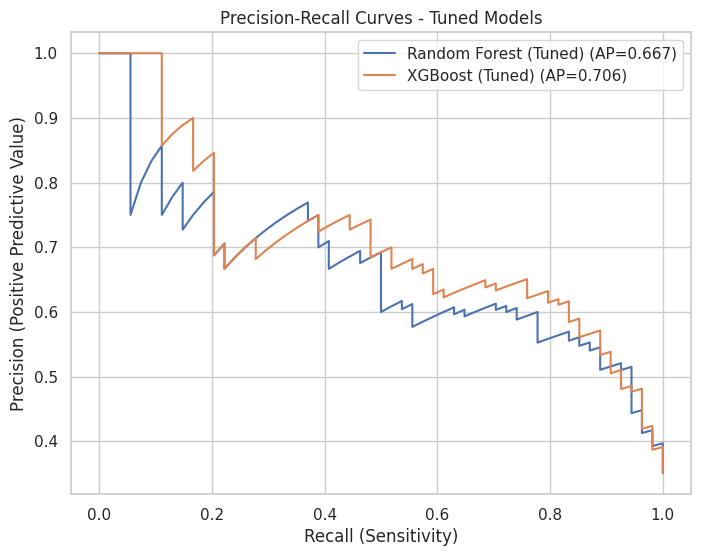

Best RF threshold for recall>=70%: 0.4049019715393356 Precision: 0.6129032258064516 Recall: 0.7037037037037037
Best XGB threshold for recall>=70%: 0.42096773 Precision: 0.6440677966101694 Recall: 0.7037037037037037


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Get prediction probabilities

# We use the tuned models we trained earlier
rf_best = rf_random.best_estimator_        # best RF model from RandomizedSearchCV
xgb_best = xgb_random.best_estimator_      # best XGB model from RandomizedSearchCV

rf_probs = rf_best.predict_proba(X_test)[:,1]   # probability of being positive
xgb_probs = xgb_best.predict_proba(X_test)[:,1]

# 2. Precision-Recall curve function

def plot_pr_curves(y_test, model_probs, model_name):
    """Plot Precision-Recall curve and show best threshold point."""
    precision, recall, thresholds = precision_recall_curve(y_test, model_probs)
    avg_prec = average_precision_score(y_test, model_probs)

    plt.plot(recall, precision, label=f"{model_name} (AP={avg_prec:.3f})")

    return precision, recall, thresholds

# 3. Plot PR curves for both models

plt.figure(figsize=(8,6))
precision_rf, recall_rf, thresholds_rf = plot_pr_curves(y_test, rf_probs, "Random Forest (Tuned)")
precision_xgb, recall_xgb, thresholds_xgb = plot_pr_curves(y_test, xgb_probs, "XGBoost (Tuned)")

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (Positive Predictive Value)")
plt.title("Precision-Recall Curves - Tuned Models")
plt.legend()
plt.grid(True)
plt.show()

# 4. Example: Find best threshold for Recall

# Let's say we want recall >= 0.70 (70%)
desired_recall = 0.70

# For Random Forest
rf_idx = np.where(recall_rf >= desired_recall)[0][-1]  # last index where recall>=0.70
print("Best RF threshold for recall>=70%:", thresholds_rf[rf_idx],
      "Precision:", precision_rf[rf_idx], "Recall:", recall_rf[rf_idx])

# For XGBoost
xgb_idx = np.where(recall_xgb >= desired_recall)[0][-1]
print("Best XGB threshold for recall>=70%:", thresholds_xgb[xgb_idx],
      "Precision:", precision_xgb[xgb_idx], "Recall:", recall_xgb[xgb_idx])

### **Key Findings from Threshold Tuning**

**Random Forest** (Tuned)

Best threshold for ≥70% Recall: ~0.405

**Precision: ~0.61**

**Recall: ~0.704**

By lowering the cutoff from 0.5 → 0.405, we recover recall (catch more positives) at the cost of more false alarms.

**XGBoost** (Tuned)
Best threshold for ≥70% Recall: ~0.421

**Precision: ~0.64**

**Recall: ~0.704**

Almost the same recall as RF, but with slightly higher precision → XGBoost is more reliable when predicting positives.

### **Precision‑Recall Curve Insight**

XGBoost stays above Random Forest across much of the curve **(AP = 0.706 vs 0.667)**.
This means that XGBoost gives better tradeoffs overall between catching diabetics and avoiding false alarms.

### **Step 5.d: ROC CURVE COMPARISON: Default vs Tuned Models**

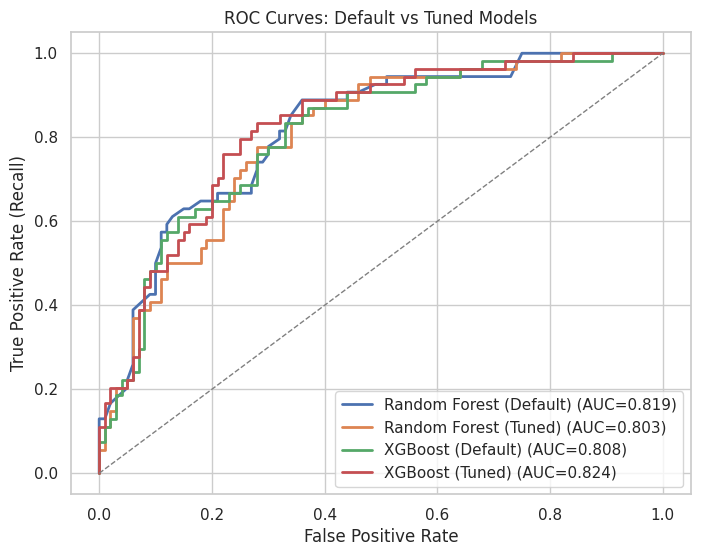

In [13]:
from sklearn.metrics import roc_curve, auc

# 1. Get probabilities

# Default models (before tuning)
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)
rf_default_probs = rf_default.predict_proba(X_test)[:, 1]

xgb_default = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_default.fit(X_train, y_train)
xgb_default_probs = xgb_default.predict_proba(X_test)[:, 1]

# Tuned models (already available)
rf_tuned_probs = rf_best.predict_proba(X_test)[:, 1]   # best estimator from tuning
xgb_tuned_probs = xgb_best.predict_proba(X_test)[:, 1]

# 2. Function to plot ROC

def plot_roc_curve(y_true, probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC={roc_auc:.3f})")

# 3. Plot ROC curves

plt.figure(figsize=(8, 6))

plot_roc_curve(y_test, rf_default_probs, "Random Forest (Default)")
plot_roc_curve(y_test, rf_tuned_probs, "Random Forest (Tuned)")
plot_roc_curve(y_test, xgb_default_probs, "XGBoost (Default)")
plot_roc_curve(y_test, xgb_tuned_probs, "XGBoost (Tuned)")

plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")  # baseline

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves: Default vs Tuned Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### **Interpretation of ROC Curve Results**

| Model                  | ROC‑AUC |
|-------------------------|---------|
| Random Forest (Default) | **0.819** |
| Random Forest (Tuned)   | 0.803 |
| XGBoost (Default)       | 0.808 |
| XGBoost (Tuned)         | **0.824** |

---

#### **Key Takeaways**
- **Random Forest**: Tuning actually lowered ROC‑AUC a bit (0.819 → 0.803).  
  This is consistent with what we saw earlier — simpler trees meant less overfitting but also weaker recall.  
- **XGBoost**: Tuning improved ROC‑AUC (0.808 → 0.824), making it the **best model overall** in terms of probability ranking and separation.  
- **All models** are well above **0.70 AUC**, which indicates good discriminative power.

### **Step 5.e: Confusion Matrix Heatmaps** (Default vs Tuned Thresholds)

This will let us show exactly how predictions shift between default 0.5 cutoff and your new recall‑optimized thresholds (~0.40 for RF, ~0.42 for XGB).

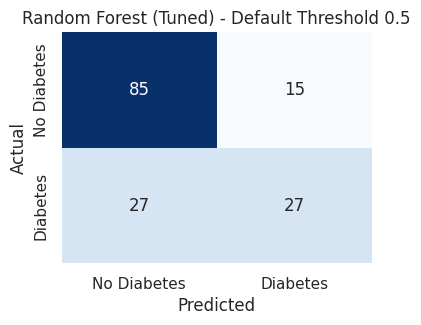

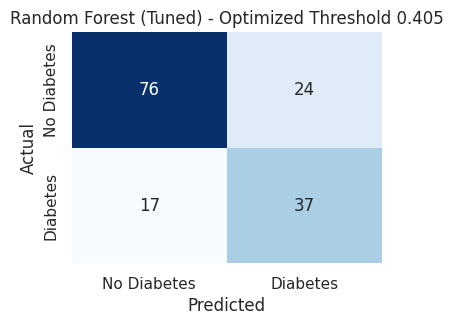

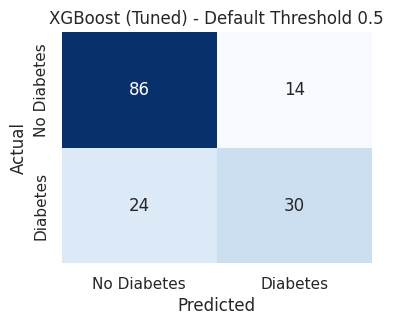

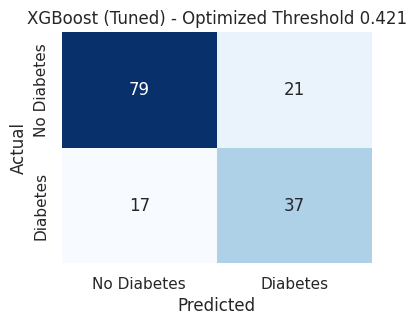

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Function to plot CM

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Diabetes", "Diabetes"],
                yticklabels=["No Diabetes", "Diabetes"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# 2. RF: Default 0.5 cutoff

rf_default_preds = (rf_best.predict_proba(X_test)[:,1] >= 0.5).astype(int)
plot_conf_matrix(y_test, rf_default_preds, "Random Forest (Tuned) - Default Threshold 0.5")

# RF: Optimized 0.405 threshold
rf_opt_preds = (rf_best.predict_proba(X_test)[:,1] >= 0.405).astype(int)
plot_conf_matrix(y_test, rf_opt_preds, "Random Forest (Tuned) - Optimized Threshold 0.405")

# 3. XGB: Default 0.5 cutoff

xgb_default_preds = (xgb_best.predict_proba(X_test)[:,1] >= 0.5).astype(int)
plot_conf_matrix(y_test, xgb_default_preds, "XGBoost (Tuned) - Default Threshold 0.5")

# XGB: Optimized 0.421 threshold
xgb_opt_preds = (xgb_best.predict_proba(X_test)[:,1] >= 0.421).astype(int)
plot_conf_matrix(y_test, xgb_opt_preds, "XGBoost (Tuned) - Optimized Threshold 0.421")

### **Summary of Confusion Matrices**

**Random Forest**: High precision at default, but low recall. Optimized threshold improves recall meaningfully.

**XGBoost**: Already balanced at default, and optimized threshold gives the best recall (~0.70), making it the most reliable model for screening.

### **Step 5.f: FEATURE IMPORTANCE PLOTS - Random Forest & XGBoost**

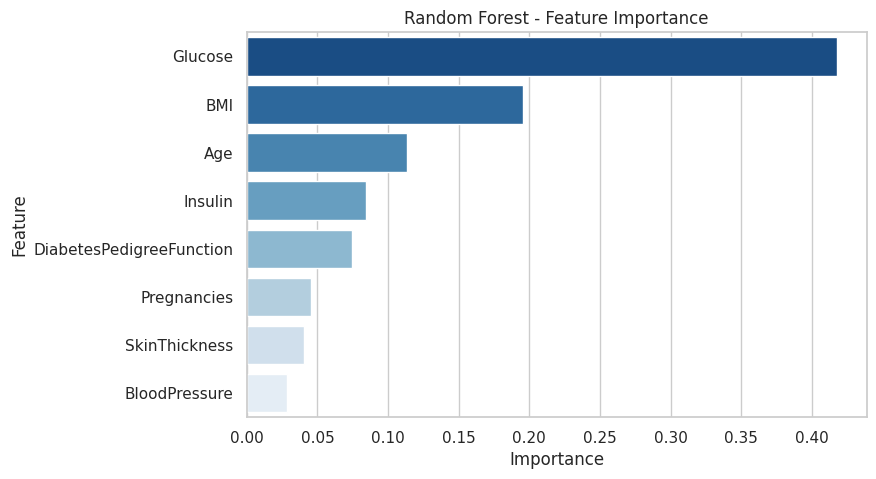

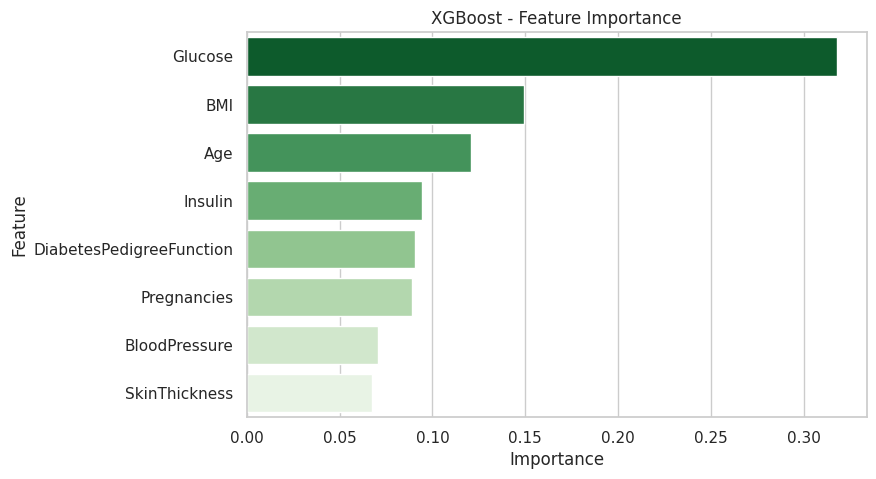

In [15]:
import numpy as np
import pandas as pd

# Random Forest importances
rf_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
rf_importances = rf_importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="Blues_r")
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# XGBoost importances
xgb_importances = pd.Series(xgb_best.feature_importances_, index=X_train.columns)
xgb_importances = xgb_importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette="Greens_r")
plt.title("XGBoost - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### **Random Forest – Feature Importances**

| Rank | Feature                | Importance |
|------|-------------------------|------------|
| 1    | Glucose                | 0.42 |
| 2    | BMI                     | 0.19 |
| 3    | Age                     | 0.12 |
| 4    | Insulin                 | 0.08 |
| 5    | DiabetesPedigreeFunction | 0.07 |
| 6    | Pregnancies             | 0.05 |
| 7    | SkinThickness           | 0.04 |
| 8    | BloodPressure           | 0.03 |

---

#### **Key Interpretation**
- **Glucose** is by far the dominant predictor (>40% of the model’s decision power).  
- **BMI** and **Age** are also strong contributors, consistent with known diabetes risk factors.  
- **Insulin** and **DiabetesPedigreeFunction** add moderate value.  
- **Pregnancies, SkinThickness, and BloodPressure** have relatively small influence on Random Forest predictions.  
- This aligns with medical knowledge: **blood glucose and obesity (BMI)** are central to diabetes detection.


### **XGBoost – Feature Importances**

| Rank | Feature                | Importance |
|------|-------------------------|------------|
| 1    | Glucose                | 0.32 |
| 2    | BMI                     | 0.15 |
| 3    | Age                     | 0.12 |
| 4    | Insulin                 | 0.09 |
| 5    | DiabetesPedigreeFunction | 0.09 |
| 6    | Pregnancies             | 0.09 |
| 7    | BloodPressure           | 0.07 |
| 8    | SkinThickness           | 0.06 |

---

#### **Key Interpretation**
- **Glucose** remains the strongest predictor, though slightly less dominant than in Random Forest.  
- **BMI and Age** together contribute nearly as much as Glucose, showing XGBoost spreads importance more evenly.  
- **Insulin, Pedigree, and Pregnancies** each provide moderate influence, indicating XGBoost considers a wider set of features.  
- **Blood Pressure and Skin Thickness** show smaller but still non‑negligible contributions compared to RF.  
- This distribution suggests XGBoost captures **multi‑factor interactions** better, balancing medical variables rather than over‑weighting Glucose.